In [1]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def balanced_error_rate(y_true, y_test):
    
    conf = confusion_matrix(y_true, y_test)
    
    return 0.5 * (conf[0,1] / conf[0].sum()) + 0.5 * (conf[1,0] / conf[1].sum())

def error_metrics(y_true, y_test):
    
    print('BER: ', balanced_error_rate(y_true, y_test))
    print('F1: ', f1_score(y_true, y_test))

In [5]:
def load_data(data_name):
    '''data_name:  'arcene', 'dorothea', 'gisette', 'dexter', or 'madelon'. '''
    
    fp = '/home/james/anaconda3/data/' + data_name.upper() + '/'
    
    if data_name not in ['dorothea', 'dexter']:
        
        X_train = np.loadtxt(fp + data_name + '_train.data')
        y_train = np.loadtxt(fp + data_name + '_train.labels')
        X_test = np.loadtxt(fp + data_name + '_valid.data')
        y_test = np.loadtxt(fp + data_name + '_valid.labels')
        y_train = np.asanyarray((y_train + 1) // 2, dtype = 'i8')
        y_test = np.asanyarray((y_test + 1) // 2, dtype = 'i8')
        
    else:
        
        X_train = np.load(fp + data_name + '_train.npy')
        y_train = np.loadtxt(fp + data_name + '_train.labels')
        X_test = np.load(fp + data_name + '_valid.npy')
        y_test = np.loadtxt(fp + data_name + '_valid.labels')
        y_train = np.asanyarray((y_train + 1) // 2, dtype = 'i8')
        y_test = np.asanyarray((y_test + 1) // 2, dtype = 'i8')
        
        
    print(data_name.upper() + ' Data:')
    print('Training data info: ')
    print(X_train.shape[0], ' samples, ', X_train.shape[1], ' features.')
    print(int(y_train.sum()), ' positve samples, ', int(X_train.shape[0] - y_train.sum()), ' negative samples')
    print('-------------------------------')
    print('Test data info: ')
    print(X_test.shape[0], ' samples.')
    print(int(y_test.sum()), ' positve samples, ', int(X_test.shape[0] - y_test.sum()), ' negative samples')
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = load_data('arcene')

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples


In [9]:
clf = LogisticRegression(C=0.0001, class_weight='balanced')

In [117]:
#clf = SVC(class_weight='balanced')

In [10]:
clf.fit(X_train, y_train)
print('Logistic Regression on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))

Logistic Regression on Full Feature Space
-----------------------------------------
BER:  0.167207792208
F1:  0.809523809524


In [11]:
class Particle(object):
    
    def __init__(self, tot_feat, c_s='def'):
        
        if c_s == 'def':
            
            choice_size = np.random.choice(np.arange(1,tot_feat))
            
        else:
            
            choice_size = np.random.choice(np.arange(1,c_s))
            
        self.locs = np.sort(np.random.choice(np.arange(tot_feat),
                                             size=choice_size,
                                             replace=False))
        self.p = np.zeros(tot_feat, dtype='i8')
        self.v = np.zeros(tot_feat)
        self.p[self.locs] = np.ones(len(self.locs), dtype='i8')
        self.num_feats = int(self.p.sum())
        self.p_best = np.copy(self.p)
        self.ber_best = 1
        self.ber = None
        self.f1 = None
        self.auc = None
        
    def fit_clf(self, clf, size_reg,  X_train, y_train):
        
        clf.fit(X_train[:,self.locs], y_train)
        self.ber = balanced_error_rate(y_test, clf.predict(X_test[:,self.locs]))
        self.f1 = f1_score(y_test, clf.predict(X_test[:,self.locs]))
        self.auc = roc_auc_score(y_test, clf.predict(X_test[:,self.locs]))
        
        if self.ber + 0 * (self.num_feats / len(self.p)) < self.ber_best:
            
            self.p_best = np.copy(self.p)
            self.ber_best = np.copy(self.ber) + 0 * (np.copy(self.num_feats) / len(self.p))
            
    def update_locs(self):
        
        self.locs = np.where(self.p == 1)[0]
        self.num_feats = int(self.p.sum())
        
def update_velocity(part, g_best):
    
    r1, r2 = np.random.uniform(), np.random.uniform()
    part.v = part.v + (3 * r1 * (part.p_best - part.p))  + (2 * r2 * (g_best.p - part.p))
    
def logistic(v):
    
    return (1 + np.exp(-v))**(-1)

def update_position(part):
    
    S = logistic(part.v)
    r = np.random.uniform()
    new_p = np.asanyarray(S >= r, dtype='i8')
    
    if new_p.sum() != 0:
        
        part.p = new_p
        
    part.update_locs()

In [13]:
from tqdm import tqdm_notebook as tqdm

def run_pso(swarm_size, num_iter, size_reg, clf, itr=1):
    
    print('Initializing the swarm....')
    
    swarm = []

    for k in range(swarm_size):
    
        swarm.append(Particle(X_train.shape[1]))
    
    swarm[0].fit_clf(clf, size_reg, X_train, y_train)

    g_best_loc = 0
    g_best_pos = np.copy(swarm[0].p)
    g_best_score = np.copy(swarm[0].ber) + size_reg * (np.copy(swarm[0].num_feats) / len(swarm[0].p))

    for k in range(1,len(swarm)):
    
        swarm[k].fit_clf(clf, size_reg,  X_train, y_train)
    
        if g_best_score > swarm[k].ber + size_reg * (swarm[k].num_feats / len(swarm[k].p)):
        
            g_best_loc = k
            g_best_pos = np.copy(swarm[k].p)
            g_best_score = np.copy(swarm[k].ber) + size_reg * (np.copy(swarm[k].num_feats) / len(swarm[k].p))
            
    print('Iteration ', itr, ' Initial Best (BER, f1, num_feats, score): (', swarm[g_best_loc].ber,
                  ', ', swarm[g_best_loc].f1, ', ', swarm[g_best_loc].num_feats,', ', g_best_score, ')')

    for iteration in tqdm(range(num_iter)):
    
        for k in range(len(swarm)):
        
            if k != g_best_loc:
            
                update_velocity(swarm[k], swarm[g_best_loc])
                update_position(swarm[k])
                swarm[k].fit_clf(clf, size_reg, X_train, y_train)
    
        for k in range(len(swarm)):
    
            if g_best_score > swarm[k].ber + size_reg * (swarm[k].num_feats / len(swarm[k].p)):
            
                g_best_loc = k
                g_best_pos = np.copy(swarm[k].p)
                g_best_score = np.copy(swarm[k].ber) + size_reg * (np.copy(swarm[k].num_feats) / len(swarm[k].p))
                print(' Iteration ', itr, ' Current Best (BER, f1, num_feats, score): (', swarm[k].ber,
                  ', ', swarm[k].f1, ', ', swarm[k].num_feats,', ', g_best_score, ')')
                
        b_feat = int(min(len(swarm[0].p), 2 * swarm[g_best_loc].num_feats))
        rand_ind = np.random.choice(np.arange(swarm_size, dtype='i8'), replace=False, size=15)
        
        for ind in rand_ind:
            
            if ind != g_best_loc:
                
                swarm[ind] = Particle(X_train.shape[1], b_feat)
                swarm[ind].fit_clf(clf, size_reg, X_train, y_train)
            
    best_part = Particle(X_train.shape[-1])
    best_part.p = g_best_pos
    best_part.update_locs()
    best_part.fit_clf(clf, size_reg, X_train, y_train)
    
    return best_part

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.167207792208
F1:  0.809523809524
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.126623376623 ,  0.857142857143 ,  2565 ,  0.129188376623 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.126623376623 ,  0.857142857143 ,  1579 ,  0.128202376623 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.117694805195 ,  0.867469879518 ,  1513 ,  0.119207805195 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.11525974026 ,  0.870588235294 ,  2308 ,  0.11756774026 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.106331168831 ,  0.8

/home/james/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  353 ,  0.0320088441558 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  352 ,  0.0320078441558 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  349 ,  0.0320048441558 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  333 ,  0.0319888441558 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  330 ,  0.0319858441558 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  327 ,  0.0319828441558 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  326 ,  0.0230532727273 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0227272727273 ,  0.976744186047 ,  317 ,  0.0230442727273 )
 Iteration  1  Current Best (BER

 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  123 ,  0.0114866363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  122 ,  0.0114856363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  120 ,  0.0114836363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  119 ,  0.0114826363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  118 ,  0.0114816363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  117 ,  0.0114806363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  114 ,  0.0114776363636 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0113636363636 ,  0.988505747126 ,  113 ,  0.0114766363636 )
 Iteration  1  Current Best (BER

 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0584415584416 ,  0.933333333333 ,  758 ,  0.0591995584416 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0584415584416 ,  0.933333333333 ,  646 ,  0.0590875584416 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0584415584416 ,  0.933333333333 ,  645 ,  0.0590865584416 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0584415584416 ,  0.933333333333 ,  627 ,  0.0590685584416 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0584415584416 ,  0.933333333333 ,  625 ,  0.0590665584416 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0470779220779 ,  0.945054945055 ,  595 ,  0.0476729220779 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0381493506494 ,  0.955555555556 ,  598 ,  0.0387473506494 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0381493506494 ,  0.955555555556 ,  592 ,  0.0387413506494 )
 Iteration  2  Current Best (BER

 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  194 ,  0.0269797142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  184 ,  0.0269697142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  183 ,  0.0269687142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  182 ,  0.0269677142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  179 ,  0.0269647142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  175 ,  0.0269607142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  171 ,  0.0269567142857 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0267857142857 ,  0.967032967033 ,  168 ,  0.0269537142857 )
 Iteration  2  Current Best (BER

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  391 ,  0.0523390519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  390 ,  0.0523380519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  384 ,  0.0523320519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  378 ,  0.0523260519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  372 ,  0.0523200519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  368 ,  0.0523160519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  361 ,  0.0523090519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  360 ,  0.0523080519481 )
 Iteration  3  Current Best (BER

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  178 ,  0.0521260519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  175 ,  0.0521230519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  170 ,  0.0521180519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  169 ,  0.0521170519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  167 ,  0.0521150519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  166 ,  0.0521140519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  165 ,  0.0521130519481 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0519480519481 ,  0.942528735632 ,  164 ,  0.0521120519481 )
 Iteration  3  Current Best (BER

 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  258 ,  0.0976605974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  253 ,  0.0976555974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  251 ,  0.0976535974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  249 ,  0.0976515974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  245 ,  0.0976475974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  243 ,  0.0976455974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  240 ,  0.0976425974026 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0974025974026 ,  0.89156626506 ,  238 ,  0.0976405974026 )
 Iteration  4  Current Best (BER, f1, nu

 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  128 ,  0.0748033246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  127 ,  0.0748023246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  125 ,  0.0748003246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  123 ,  0.0747983246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  122 ,  0.0747973246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  121 ,  0.0747963246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  119 ,  0.0747943246753 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0746753246753 ,  0.917647058824 ,  118 ,  0.0747933246753 )
 Iteration  4  Current Best (BER

 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  219 ,  0.0318748441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  218 ,  0.0318738441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  213 ,  0.0318688441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  208 ,  0.0318638441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  207 ,  0.0318628441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  206 ,  0.0318618441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  203 ,  0.0318588441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  199 ,  0.0318548441558 )
 Iteration  5  Current Best (BER

 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  102 ,  0.0317578441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  101 ,  0.0317568441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  100 ,  0.0317558441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  99 ,  0.0317548441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  97 ,  0.0317528441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  96 ,  0.0317518441558 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0316558441558 ,  0.965517241379 ,  95 ,  0.0317508441558 )



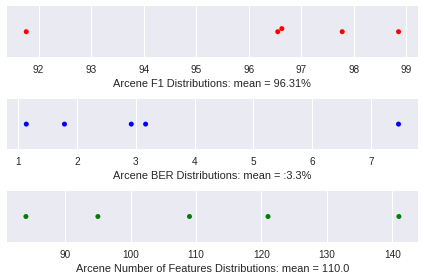

In [14]:
# Run Arcene Test

X_train, y_train, X_test, y_test = load_data('arcene')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_arcene = []

for exp in range(5):
    
    best_arcene.append(run_pso(150, 100, 0.01, clf, exp+1))
    
arcene_ber = np.asanyarray([100*x.ber for x in best_arcene])
arcene_f1 = np.asanyarray([100*x.f1 for x in best_arcene])
arcene_num_feats = np.asanyarray([x.num_feats for x in best_arcene])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(arcene_f1, color='r', ax=ax1)
ax1.set_xlabel('Arcene F1 Distributions: mean = ' + str(round(arcene_f1.mean(),2)) + '%')
sns.swarmplot(arcene_ber, color='b', ax=ax2)
ax2.set_xlabel('Arcene BER Distributions: mean = :' + str(round(arcene_ber.mean(),2)) + '%')
sns.swarmplot(arcene_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Arcene Number of Features Distributions: mean = ' + str(arcene_num_feats.mean()) )
plt.tight_layout()

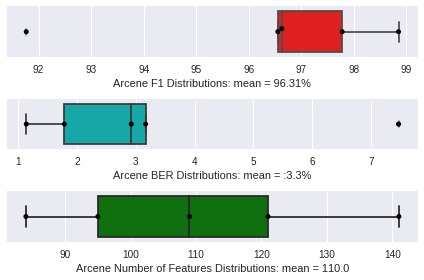

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(arcene_f1, color='k', ax=ax1)
sns.boxplot(arcene_f1, color='r', ax=ax1)
ax1.set_xlabel('Arcene F1 Distributions: mean = ' + str(round(arcene_f1.mean(),2)) + '%')
sns.swarmplot(arcene_ber, color='k', ax=ax2)
sns.boxplot(arcene_ber, color='c', ax=ax2)
ax2.set_xlabel('Arcene BER Distributions: mean = :' + str(round(arcene_ber.mean(),2)) + '%')
sns.swarmplot(arcene_num_feats, color='k', ax=ax3)
sns.boxplot(arcene_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Arcene Number of Features Distributions: mean = ' + str(arcene_num_feats.mean()) )
plt.tight_layout()

DEXTER Data:
Training data info: 
300  samples,  20000  features.
150  positve samples,  150  negative samples
-------------------------------
Test data info: 
300  samples.
150  positve samples,  150  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.0733333333333
F1:  0.929936305732
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.0566666666667 ,  0.94498381877 ,  19410 ,  0.0663716666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0566666666667 ,  0.94498381877 ,  19122 ,  0.0662276666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960264900662 ,  12119 ,  0.0460595 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960264900662 ,  12109 ,  0.0460545 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  1

/home/james/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  12509 ,  0.0429211666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  12443 ,  0.0428881666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  12403 ,  0.0428681666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  12195 ,  0.0427641666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  11586 ,  0.0424596666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.963696369637 ,  11575 ,  0.0424541666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0333333333333 ,  0.966887417219 ,  11858 ,  0.0392623333333 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0333333333333 ,  0.966887417219 ,  11711 ,  0.0391888333333 )
 Iteration  1  C

 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11899 ,  0.0492828333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11796 ,  0.0492313333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11764 ,  0.0492153333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11762 ,  0.0492143333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11722 ,  0.0491943333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11706 ,  0.0491863333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11680 ,  0.0491733333333 )
 Iteration  2  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.956810631229 ,  11618 ,  0.0491423333333 )
 Iteration  2  C

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13522 ,  0.046761 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13476 ,  0.046738 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13463 ,  0.0467315 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13359 ,  0.0466795 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13296 ,  0.046648 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13290 ,  0.046645 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13278 ,  0.046639 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  13276 ,  0.046638 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.960784313725 ,  12473 ,  0.0462365 )
 Iteration  3  Current Best (BER, f1, num_feats, sco

 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.04 ,  0.961038961039 ,  10777 ,  0.0453885 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10979 ,  0.0421561666667 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10839 ,  0.0420861666667 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10786 ,  0.0420596666667 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10778 ,  0.0420556666667 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10770 ,  0.0420516666667 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10737 ,  0.0420351666667 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0366666666667 ,  0.964169381107 ,  10733 ,  0.0420331666667 )
 Iteration  4  Current Best (BER,

 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954545454545 ,  12796 ,  0.0530646666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954545454545 ,  12702 ,  0.0530176666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954545454545 ,  12678 ,  0.0530056666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954545454545 ,  12657 ,  0.0529951666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954545454545 ,  12636 ,  0.0529846666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954545454545 ,  12627 ,  0.0529801666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0466666666667 ,  0.954248366013 ,  12286 ,  0.0528096666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0433333333333 ,  0.957654723127 ,  12206 ,  0.0494363333333 )
 Iteration  5  C

 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0266666666667 ,  0.973684210526 ,  11456 ,  0.0323946666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0266666666667 ,  0.973684210526 ,  11300 ,  0.0323166666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0266666666667 ,  0.973684210526 ,  11298 ,  0.0323156666667 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0266666666667 ,  0.973684210526 ,  11296 ,  0.0323146666667 )



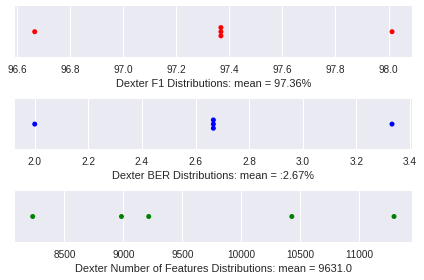

In [16]:
# Run Dexter Test

X_train, y_train, X_test, y_test = load_data('dexter')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_dex = []

for exp in range(5):
    
    best_dex.append(run_pso(150, 100, 0.01, clf, exp+1))
    
dex_ber = np.asanyarray([100*x.ber for x in best_dex])
dex_f1 = np.asanyarray([100*x.f1 for x in best_dex])
dex_num_feats = np.asanyarray([x.num_feats for x in best_dex])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(dex_f1, color='r', ax=ax1)
ax1.set_xlabel('Dexter F1 Distributions: mean = ' + str(round(dex_f1.mean(),2)) + '%')
sns.swarmplot(dex_ber, color='b', ax=ax2)
ax2.set_xlabel('Dexter BER Distributions: mean = :' + str(round(dex_ber.mean(),2)) + '%')
sns.swarmplot(dex_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Dexter Number of Features Distributions: mean = ' + str(dex_num_feats.mean()) )
plt.tight_layout()

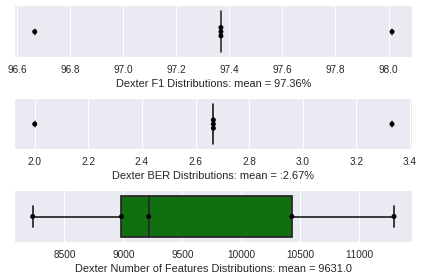

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(dex_f1, color='k', ax=ax1)
sns.boxplot(dex_f1, color='r', ax=ax1)
ax1.set_xlabel('Dexter F1 Distributions: mean = ' + str(round(dex_f1.mean(),2)) + '%')
sns.swarmplot(dex_ber, color='k', ax=ax2)
sns.boxplot(dex_ber, color='c', ax=ax2)
ax2.set_xlabel('Dexter BER Distributions: mean = :' + str(round(dex_ber.mean(),2)) + '%')
sns.swarmplot(dex_num_feats, color='k', ax=ax3)
sns.boxplot(dex_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Dexter Number of Features Distributions: mean = ' + str(dex_num_feats.mean()) )
plt.tight_layout()

In [20]:
# Run Gisette Test

X_train, y_train, X_test, y_test = load_data('gisette')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_gst = []

for exp in range(5):
    
    best_gst.append(run_pso(150, 100, 0.01, clf, exp+1))
    
gst_ber = np.asanyarray([100*x.ber for x in best_gst])
gst_f1 = np.asanyarray([100*x.f1 for x in best_gst])
gst_num_feats = np.asanyarray([x.num_feats for x in best_gst])

GISETTE Data:
Training data info: 
6000  samples,  5000  features.
3000  positve samples,  3000  negative samples
-------------------------------
Test data info: 
1000  samples.
500  positve samples,  500  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.017
F1:  0.98294884654
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.017 ,  0.98294884654 ,  3608 ,  0.024216 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.016 ,  0.983935742972 ,  4039 ,  0.024078 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.018 ,  0.981891348089 ,  3020 ,  0.02404 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.017 ,  0.982914572864 ,  3363 ,  0.023726 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.017 ,  0.98294884654 ,  3204 ,  0.023408 )
 Iteration  1  Current Best (BER, f1, 

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2980 ,  0.01796 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2957 ,  0.017914 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2941 ,  0.017882 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2885 ,  0.01777 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2829 ,  0.017658 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2826 ,  0.017652 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2825 ,  0.01765 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2821 ,  0.017642 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.012 ,  0.987975951904 ,  2800 ,  0.0176 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0

 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.015 ,  0.984984984985 ,  2471 ,  0.019942 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.016 ,  0.984 ,  1917 ,  0.019834 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.015 ,  0.985014985015 ,  1865 ,  0.01873 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.015 ,  0.984984984985 ,  1716 ,  0.018432 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.014 ,  0.986 ,  1719 ,  0.017438 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.014 ,  0.986 ,  1718 ,  0.017436 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.014 ,  0.986 ,  1717 ,  0.017434 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.014 ,  0.986 ,  1715 ,  0.01743 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.014 ,  0.986 ,  1714 ,  0.017428 )



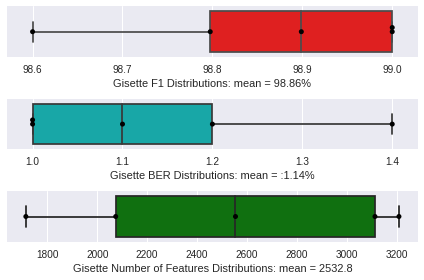

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(gst_f1, color='k', ax=ax1)
sns.boxplot(gst_f1, color='r', ax=ax1)
ax1.set_xlabel('Gisette F1 Distributions: mean = ' + str(round(gst_f1.mean(),2)) + '%')
sns.swarmplot(gst_ber, color='k', ax=ax2)
sns.boxplot(gst_ber, color='c', ax=ax2)
ax2.set_xlabel('Gisette BER Distributions: mean = :' + str(round(gst_ber.mean(),2)) + '%')
sns.swarmplot(gst_num_feats, color='k', ax=ax3)
sns.boxplot(gst_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Gisette Number of Features Distributions: mean = ' + str(gst_num_feats.mean()) )
plt.tight_layout()

In [23]:
# Run Dorothea Test

X_train, y_train, X_test, y_test = load_data('dorothea')
clf.fit(X_train, y_train)
print('-----------------------------------------')
print('Performance on Full Feature Space')
print('-----------------------------------------')
error_metrics(y_test, clf.predict(X_test))
print('-----------------------------------------')

best_dor = []

for exp in range(5):
    
    best_dor.append(run_pso(150, 100, 0.01, clf, exp+1))
    
dor_ber = np.asanyarray([100*x.ber for x in best_dor])
dor_f1 = np.asanyarray([100*x.f1 for x in best_dor])
dor_num_feats = np.asanyarray([x.num_feats for x in best_dor])

DOROTHEA Data:
Training data info: 
800  samples,  100000  features.
78  positve samples,  722  negative samples
-------------------------------
Test data info: 
350  samples.
34  positve samples,  316  negative samples
-----------------------------------------
Performance on Full Feature Space
-----------------------------------------
BER:  0.138216679077
F1:  0.712328767123
-----------------------------------------
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.0963328369322 ,  0.632653061224 ,  37058 ,  0.100038636932 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0963328369322 ,  0.632653061224 ,  36617 ,  0.0999945369322 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0947505584512 ,  0.639175257732 ,  35758 ,  0.0983263584512 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0800446760983 ,  0.65306122449 ,  42146 ,  0.0842592760983 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.07

/home/james/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0605919583023 ,  0.6875 ,  43130 ,  0.0649049583023 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0605919583023 ,  0.6875 ,  43103 ,  0.0649022583023 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0605919583023 ,  0.6875 ,  39735 ,  0.0645654583023 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0605919583023 ,  0.6875 ,  39714 ,  0.0645633583023 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0590096798213 ,  0.694736842105 ,  41415 ,  0.0631511798213 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0590096798213 ,  0.694736842105 ,  41053 ,  0.0631149798213 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0590096798213 ,  0.694736842105 ,  41037 ,  0.0631133798213 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0590096798213 ,  0.694736842105 ,  40011 ,  0.0630107798213 )
 Iteration  1  Current Best (BER, f1, num_feats,

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0800446760983 ,  0.65306122449 ,  22085 ,  0.0822531760983 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0800446760983 ,  0.65306122449 ,  22083 ,  0.0822529760983 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0784623976173 ,  0.659793814433 ,  22031 ,  0.0806654976173 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0784623976173 ,  0.659793814433 ,  22027 ,  0.0806650976173 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0784623976173 ,  0.659793814433 ,  22026 ,  0.0806649976173 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0784623976173 ,  0.659793814433 ,  22019 ,  0.0806642976173 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0784623976173 ,  0.659793814433 ,  22016 ,  0.0806639976173 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0784623976173 ,  0.659793814433 ,  22015 ,  0.0806638976173 )
 Iteration  3  Cur

 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0626396128071 ,  0.735632183908 ,  31376 ,  0.0657772128071 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0626396128071 ,  0.735632183908 ,  31317 ,  0.0657713128071 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0626396128071 ,  0.735632183908 ,  31288 ,  0.0657684128071 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0626396128071 ,  0.735632183908 ,  30806 ,  0.0657202128071 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0610573343261 ,  0.744186046512 ,  31238 ,  0.0641811343261 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0610573343261 ,  0.744186046512 ,  31222 ,  0.0641795343261 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0610573343261 ,  0.744186046512 ,  31188 ,  0.0641761343261 )
 Iteration  3  Current Best (BER, f1, num_feats, score): ( 0.0610573343261 ,  0.744186046512 ,  31085 ,  0.0641658343261 )
 Iteration  3  C

 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0642218912882 ,  0.727272727273 ,  29839 ,  0.0672057912882 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0642218912882 ,  0.727272727273 ,  29835 ,  0.0672053912882 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0642218912882 ,  0.727272727273 ,  29823 ,  0.0672041912882 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0642218912882 ,  0.727272727273 ,  29779 ,  0.0671997912882 )
 Iteration  4  Current Best (BER, f1, num_feats, score): ( 0.0642218912882 ,  0.727272727273 ,  29769 ,  0.0671987912882 )

Initializing the swarm....
Iteration  5  Initial Best (BER, f1, num_feats, score): ( 0.102010424423 ,  0.716049382716 ,  58179 ,  0.107828324423 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0983804914371 ,  0.674157303371 ,  39182 ,  0.102298691437 )
 Iteration  5  Current Best (BER, f1, num_feats, score): ( 0.0915860014892 ,  0.652631578947 ,  36074 ,  0.09519340

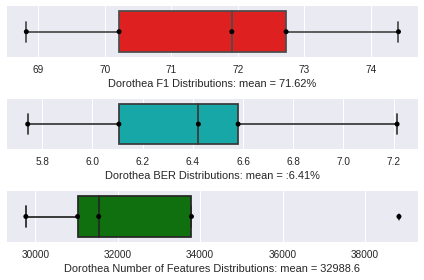

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, )
sns.swarmplot(dor_f1, color='k', ax=ax1)
sns.boxplot(dor_f1, color='r', ax=ax1)
ax1.set_xlabel('Dorothea F1 Distributions: mean = ' + str(round(dor_f1.mean(),2)) + '%')
sns.swarmplot(dor_ber, color='k', ax=ax2)
sns.boxplot(dor_ber, color='c', ax=ax2)
ax2.set_xlabel('Dorothea BER Distributions: mean = :' + str(round(dor_ber.mean(),2)) + '%')
sns.swarmplot(dor_num_feats, color='k', ax=ax3)
sns.boxplot(dor_num_feats, color='g', ax=ax3)
ax3.set_xlabel('Dorothea Number of Features Distributions: mean = ' + str(dor_num_feats.mean()) )
plt.tight_layout()